# Stroke Prediction Dataset

### Integrantes

• Christopher Sebastian, Charaf Herrera 

• Cecilia Azul, Villanueva

• Niels Pacheco

[Link del dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

Los accidentes cerebrovasculares son una preocupación significativa de salud a nivel mundial, a menudo conllevan consecuencias graves, como discapacidades a largo plazo o la muerte. Predecir la probabilidad de un accidente cerebrovascular puede desempeñar un papel crucial en la intervención y el tratamiento temprano, lo que potencialmente podría salvar vidas y mejorar los resultados para los pacientes.

En este notebook, analizaremos un conjunto de datos que contiene diversas características de los pacientes para predecir la ocurrencia de accidentes cerebrovasculares. Exploraremos diferentes modelos de aprendizaje automático, evaluaremos su rendimiento y determinaremos el enfoque más efectivo para la predicción de accidentes cerebrovasculares.

In [1]:
#IMPORTS
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, classification_report,mean_squared_error

---

## Análisis Exploratorio de datos

Cargamos el dataset

In [2]:
df = pd.read_csv("dataset\healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


Hacemos un resumen estadistico de los datos

In [3]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.00,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.10,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.00,0.00,77.25,23.50,0.00
50%,36932.00,45.00,0.00,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.00,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.00,1.00,271.74,97.60,1.00


---

## Valores nulos y outliers

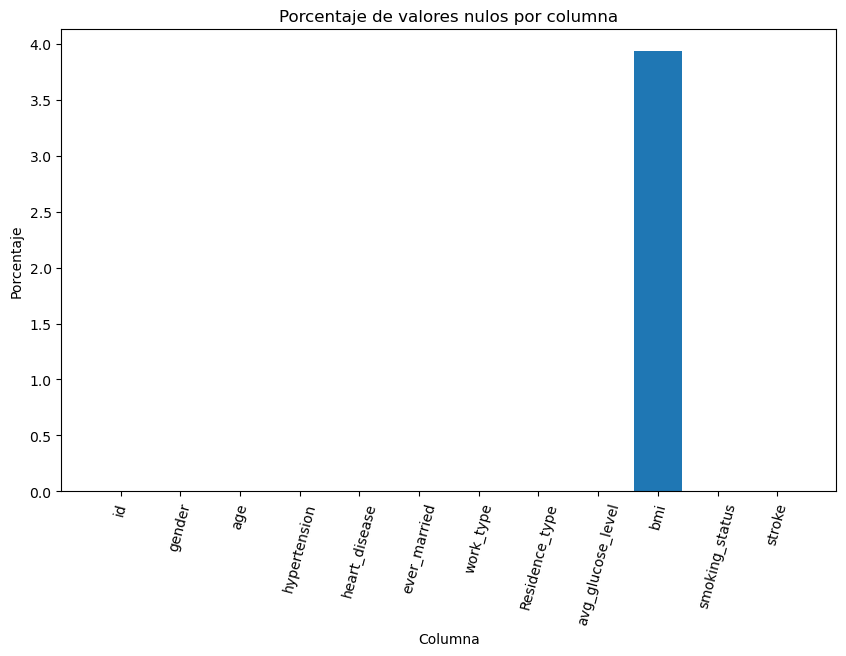

In [4]:
# Calculamos el porcentaje de nulos por columna
null_percentage = (df.isnull().sum() / len(df)) * 100


plt.figure(figsize=(10, 6))
plt.bar(null_percentage.index, null_percentage)
plt.xlabel('Columna')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de valores nulos por columna')
plt.bar(null_percentage.index, null_percentage, color='blue', alpha=0)
plt.xticks(rotation=75)
plt.show()

Revisamos el numero exacto de nulos en la columna bmi

In [5]:
null_count = df['bmi'].isnull().sum()
print("Número exacto de nulos en columna bmi:", null_count)

Número exacto de nulos en columna bmi: 201


BMI Tiene 201 valores nulos, pero antes de imputar, veamos cuantos outliers tiene

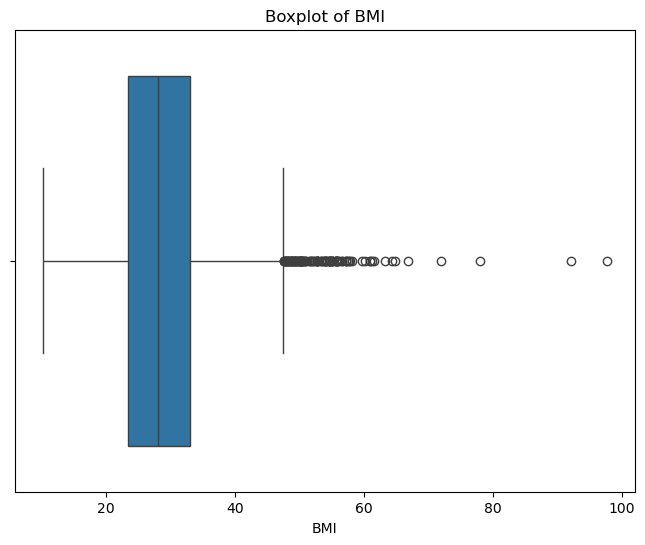

In [6]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['bmi'])
plt.xlabel('BMI')
plt.title('Boxplot of BMI')
plt.show()

In [7]:
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_count = df[(df['bmi'] < lower_bound) | (df['bmi'] > upper_bound)].shape[0]
print("Cantidad de outliers en bmi:", outliers_count)


Cantidad de outliers en bmi: 110


Del analisis anterior, no es beneficioso reemplazar los valores nulos de bmi por la media debido a los outliers, asi que reemplazaremos por la mediana

In [8]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)

Validamos el cambio

In [9]:
null_count = df['bmi'].isnull().sum()
print("Número exacto de nulos en columna bmi:", null_count)

Número exacto de nulos en columna bmi: 0


Dropeamos ID ya que no es relevante

In [10]:
df = df.drop("id",axis=1)

Usamos binary encoding para ever_married

In [11]:
df['ever_married'].value_counts()

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

In [12]:
df['ever_married'] = df['ever_married'].map({'Yes':1 ,'No':0})

In [13]:
df['ever_married'].value_counts()

ever_married
1    3353
0    1757
Name: count, dtype: int64

Gender tiene 1 valor diferente que es Other, por lo que lo eliminaremos

In [14]:
df['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [15]:
df = df[df['gender'] != 'Other']

In [16]:
df['gender'].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

Ahora solo tenemos 2 valores en Gender

---

## Analisis de variables

Analizaremos cada variable de forma individual para entenderlas mejor

### gender

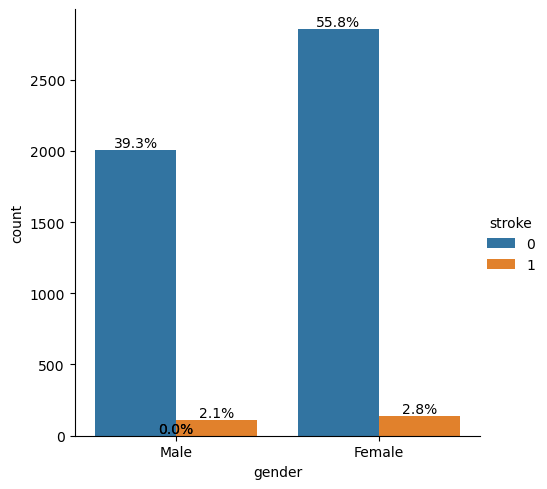

In [17]:
gender_counts = df.gender.value_counts()
total = len(df)

plot = sns.catplot(data=df, x="gender", kind="count",hue='stroke')
ax = plot.ax
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

plt.show()

Podemos interpretar que de la totalidad de los datos, hay mas mujeres que hombres, sin embargo esto no parece tener una relacion directa con qué genero experimenta mas ACVs.

### age

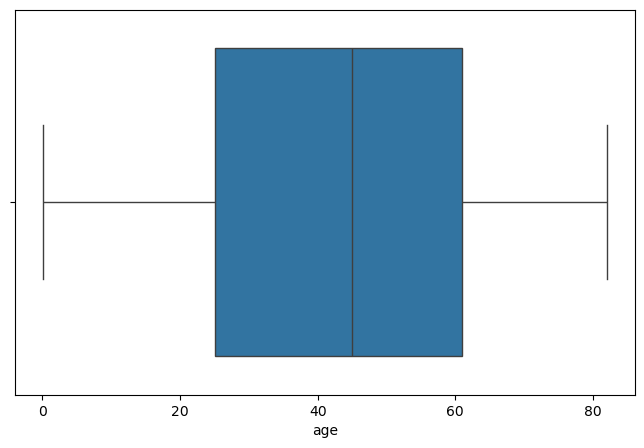

In [18]:
plt.figure(figsize = (8,5))
sns.boxplot(x = df.age)

IQR = df.describe().loc['75%','age'] - df.describe().loc['25%','age']
lower_limit = df.describe().loc['25%','age'] - 1.5*IQR
higher_limit = df.describe().loc['75%','age'] + 1.5*IQR
outliers = [val for val in df.age if (val < lower_limit or val > higher_limit)]

Age no tiene outliers, ademas podemos decir que la mediana es de 45 años en este dataframe

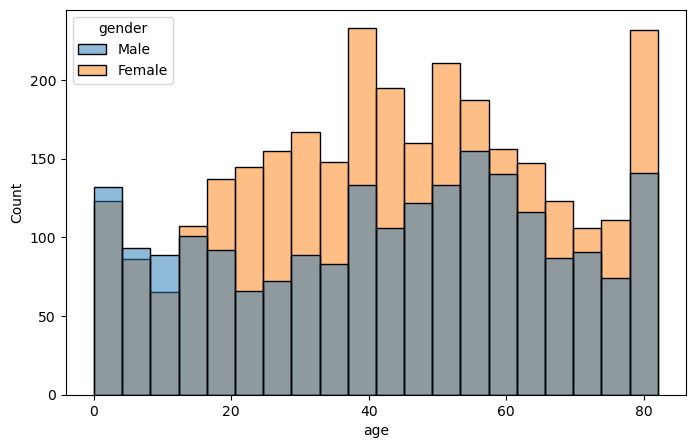

In [19]:
plt.figure(figsize = (8,5))
sns.histplot(data=df, x=df.age, hue=df.gender, multiple="layer", bins=20)
plt.show()

Relacionando a gender, podemos ver que hay mas mujeres en los rangos de edad mayores a 15, mientras que hay mas hombres en el rango de menores a 15.

### hypertension

In [20]:
def display_column_counts(column_name):
        counts = df[column_name].value_counts()
        total = len(df)

        plot = sns.catplot(data=df, x=column_name, kind="count")
        ax = plot.ax

        for p in ax.patches:
            height = p.get_height()
            percentage = height / total * 100
            ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom')

        plt.show()

Aproximadamente 500 personas tienen hipertensión

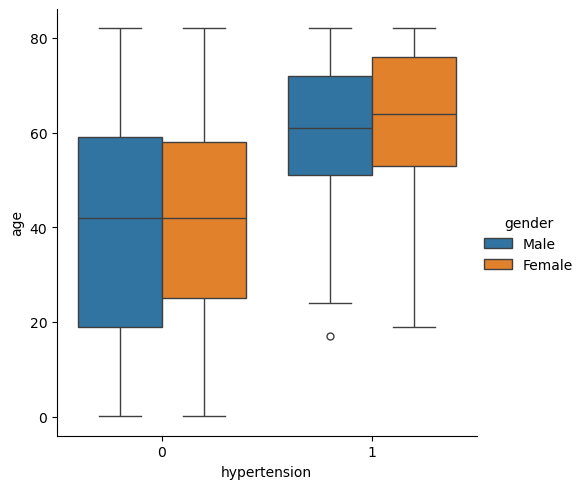

In [21]:
sns.catplot(data=df, x="hypertension", y="age", hue="gender", kind="box")
plt.show()

Del analisis anterior, podemos inferir que la mediana de edad en hombres con hipertension es menor que en mujeres.

### heart_disease

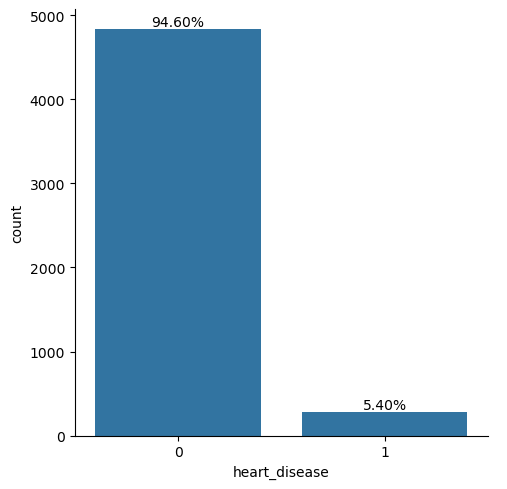

In [22]:
gender_counts = df.heart_disease.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="heart_disease", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

plt.show()

Aproximadamente menos de 300 personas sufren de enfermedades cardiacas 

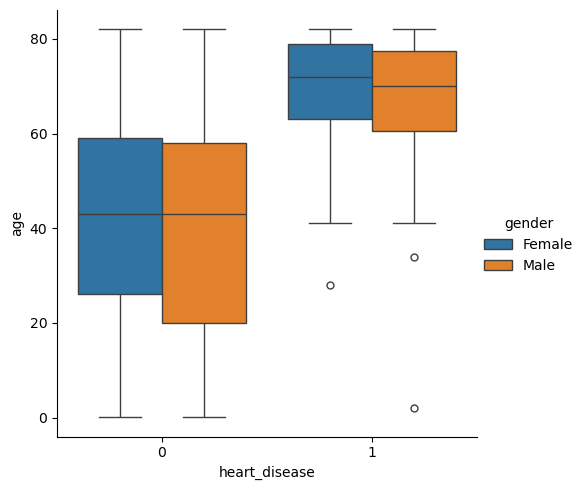

In [23]:
sns.catplot(data=df, x="heart_disease", y="age", hue="gender", kind="box")
plt.show()

Del análisis anterior, podemos concluir que el 50% de las mujeres que sufren de enfermedades cardíacas están en el rango de edad de 72 a 82 años.

De manera similar, el 50% de los hombres que sufren de enfermedades cardíacas están en el rango de edad de 70 a 82 años.

### Ever_married

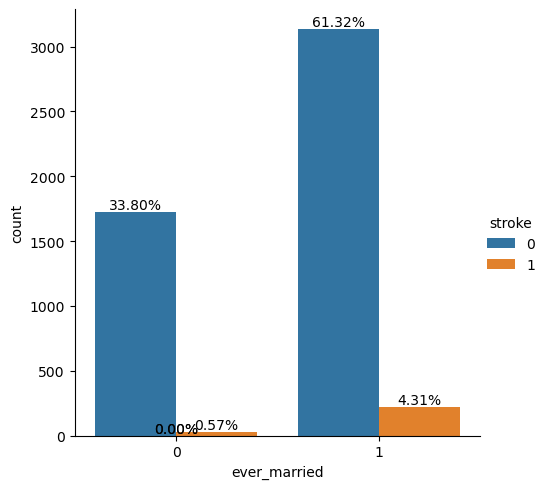

In [24]:
gender_counts = df.ever_married.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="ever_married", kind="count",hue='stroke')
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

plt.show()


Vemos que la mayoria de personas en el dataset estan o estuvieron casadas

### Work_type

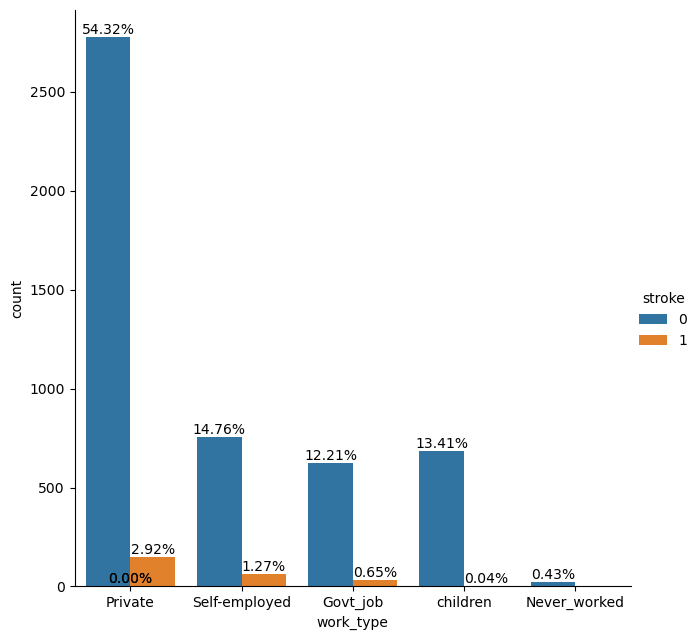

In [25]:
gender_counts = df.work_type.value_counts()
total = len(df)

# Create the count plot

plot = sns.catplot(data=df, x="work_type", kind="count", hue='stroke',height=6.5)
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

plt.show()

Podemos observar que la mayoría de las personas que sufrieron ACVs trabajan en el sector privado

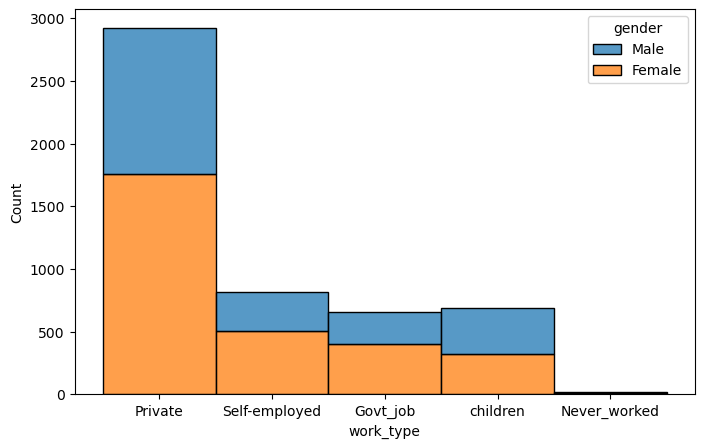

In [26]:
plt.figure(figsize = (8,5))
sns.histplot(data=df, x=df.work_type, hue=df.gender, multiple="stack", bins=20)
plt.show()

En terminos de distribucion laboral segun el sexo, ambos géneros se mantienen relativamente proporcionales

### Residence_type

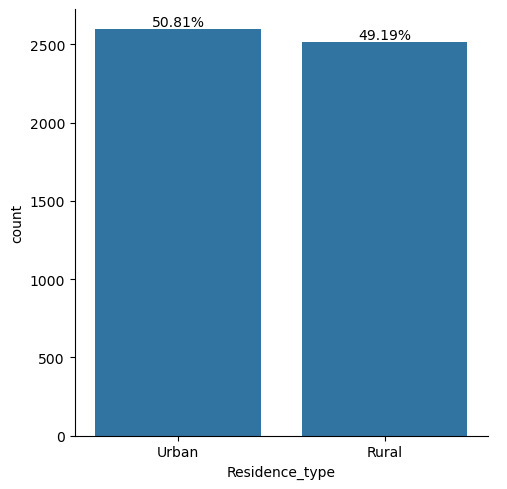

In [27]:
gender_counts = df.Residence_type.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="Residence_type", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

plt.show()

La distribucion entre gente que vive en zonas rurales vs urbanas es bastante uniforme

### avg_glucose_level

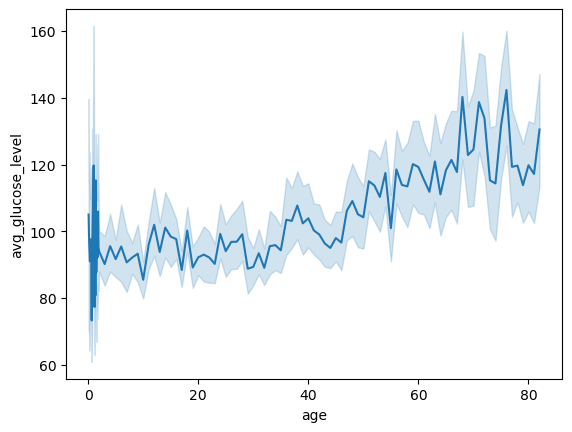

In [28]:
sns.lineplot(data=df, x="age", y="avg_glucose_level")
plt.show()

Podemos ver que el nivel promedio de glucosa en sangre aumenta con respecto a la edad

Hay 627 personas que tienen un nivel de glucosa superior a 169.365


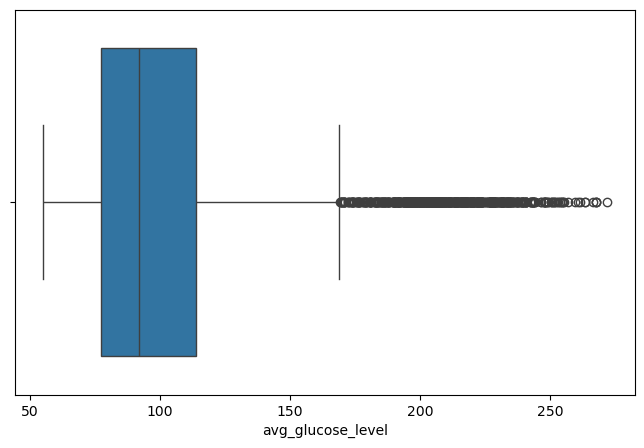

In [29]:
plt.figure(figsize = (8,5))
sns.boxplot(x = df.avg_glucose_level)

IQR = df.describe().loc['75%','avg_glucose_level'] - df.describe().loc['25%','avg_glucose_level']
lower_limit = df.describe().loc['25%','avg_glucose_level'] - 1.5*IQR
higher_limit = df.describe().loc['75%','avg_glucose_level'] + 1.5*IQR

outliers = [val for val in df.avg_glucose_level if (val < lower_limit or val > higher_limit)]
print(f'Hay {len(outliers)} personas que tienen un nivel de glucosa superior a {higher_limit}')

Hay 627 personas que tienen un nivel de glucosa superior a 169.365

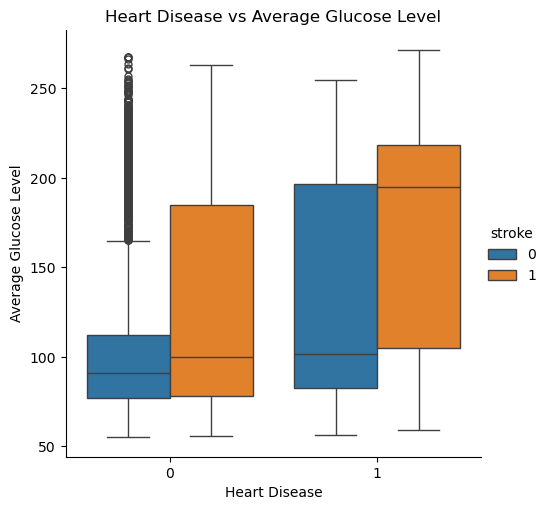

In [30]:
sns.catplot(data=df, x="heart_disease", y="avg_glucose_level", kind="box", hue="stroke")
plt.xlabel("Heart Disease")
plt.ylabel("Average Glucose Level")
plt.title("Heart Disease vs Average Glucose Level")
plt.show()

Podemos ver que la gente que sufrio ACVs tuvo niveles de glucosa altos y sufre enfermedades cardiacas preexistentes.

### bmi

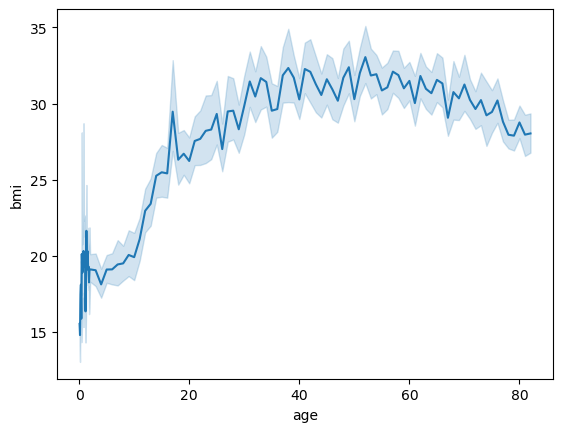

In [31]:
sns.lineplot(data=df, x="age", y="bmi")
plt.show()

Podemos ver que la gente con mas edad tiende a tener un indice de bmi mas elevado

### smoking_status

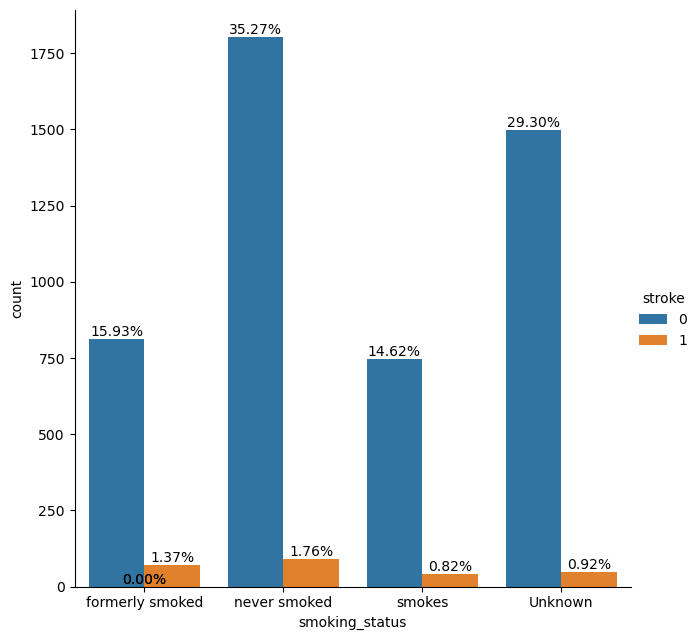

In [32]:
gender_counts = df.smoking_status.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="smoking_status", kind="count", height=6.5, hue='stroke')
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

plt.show()

Lo curioso es que la mayoria de la gente que sufrió ACVs nunca fumaron 

### stroke

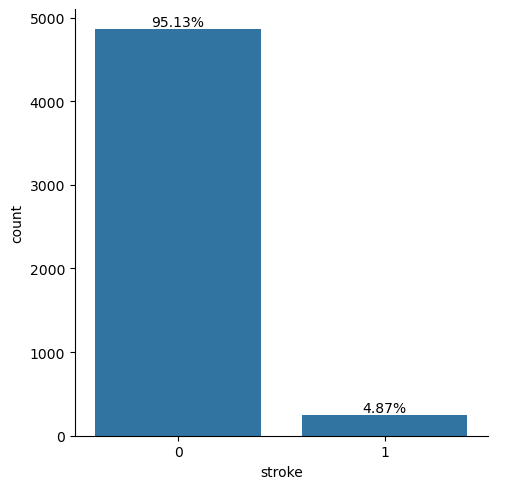

In [33]:
stroke_counts = df.stroke.value_counts()
total = len(df)

# Create the count plot
plot = sns.catplot(data=df, x="stroke", kind="count")
ax = plot.ax

# Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

plt.show()

Vemos que la variable está extremadamente desbalanceada, asi que necesitaremos manejarla para lograr una mejor distribucion.

Anteriormente vimos que habia mas mujeres que hombres que sufrieron ACVs, pero tambien vimos que hay mas mujeres que hombres en este dataset, veamos las relaciones porcentuales entre mujeres y hombres que sufrieron ACVs para tener una mejor idea de las proporciones.

In [34]:
print(df.groupby(by = 'gender')[['stroke']].sum()/df.groupby(by = 'gender')[['stroke']].count()*100)

        stroke
gender        
Female    4.71
Male      5.11


Podemos ver que los porcentajes estan un poco mas parejos, lo cual significa que no podemos concluir que las mujeres tienen mas ACVs que los hombres.

Veamos si podemos establecer una relacion entre edad y stroke:

Media de edad de personas que han sufrido un ACV
         age
stroke      
0      41.97
1      67.73


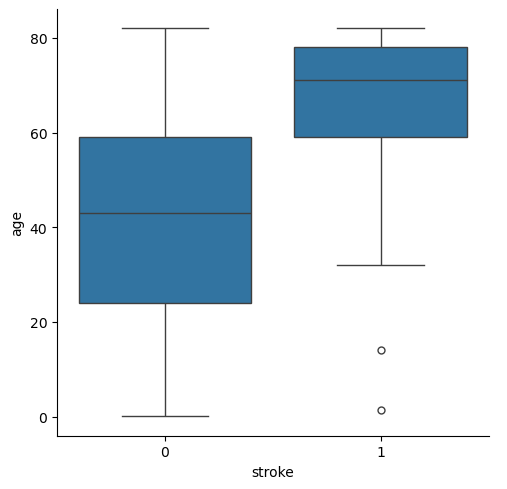

In [35]:
print("Media de edad de personas que han sufrido un ACV")
print(df.groupby(by = 'stroke')[['age']].mean())
sns.catplot(data=df, x="stroke", y="age", kind="box")
plt.show()

La media de edad de personas que sufren ACVs es de 68 años 

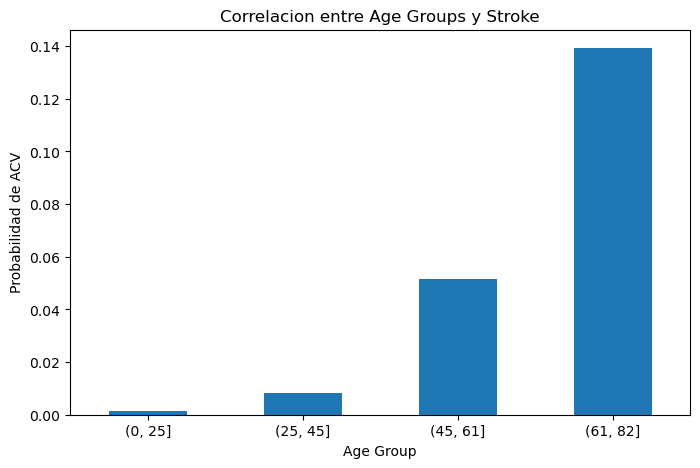

In [36]:
# Definir los rangos de edad en base a la media y la desviación estándar
age_ranges = [0, 25, 45, 61, 82]

# Crear binnings para las edades
df['age_group'] = pd.cut(df['age'], bins=age_ranges)

# Calcular la correlacion entre las edades y si tuvieron un ACV
correlation = df.groupby('age_group')['stroke'].mean()

plt.figure(figsize=(8, 5))
correlation.plot(kind='bar')
plt.xlabel('Age Group')
plt.ylabel('Probabilidad de ACV')
plt.title('Correlacion entre Age Groups y Stroke')
plt.xticks(rotation=0) 
plt.show()

---

## Feature engineering

Mas del 95% de los datos son de la clase 0, por lo que es un dataset desbalanceado, lo que puede afectar el rendimiento del modelo

### One-hot encoding

In [37]:
df = pd.get_dummies(df).astype(int)
df.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,...,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,"age_group_(0, 25]","age_group_(25, 45]","age_group_(45, 61]","age_group_(61, 82]"
0,67,0,1,1,228,36,1,0,1,0,...,0,1,0,1,0,0,0,0,0,1
1,61,0,0,1,202,28,1,1,0,0,...,1,0,0,0,1,0,0,0,1,0
2,80,0,1,1,105,32,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
3,49,0,0,1,171,34,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,79,1,0,1,174,24,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1


### Upsampling

In [38]:
# Utilizaremos SMOTE (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
# SMOTE significa Técnica de Sobremuestreo de Minorías Sintéticas.
# Es una técnica utilizada en aprendizaje automático para abordar conjuntos de datos desequilibrados.
# Identificación del Desequilibrio: comenzamos reconociendo que el conjunto de datos tiene una clase minoritaria, como casos de enfermedades raras en un conjunto de datos médicos, o en este caso la tasa de ACVs.
from imblearn.over_sampling import SMOTE

In [39]:
x = df.drop("stroke",axis=1)
y = df.stroke

In [40]:
x.shape , y.shape , y.value_counts()

((5109, 23),
 (5109,),
 stroke
 0    4860
 1     249
 Name: count, dtype: int64)

In [41]:
smote = SMOTE(sampling_strategy="minority")

In [42]:
#fiteamos
x_smote , y_smote = smote.fit_resample(x,y)                

In [43]:
# ahora tenemos el mismo numero de datos para ambas clases
y_smote.value_counts()


stroke
1    4860
0    4860
Name: count, dtype: int64

---

## Predicciones
Aplicaremos LazyPredict, Random forests y Redes neuronales

### Correlaciones con nuevas variables
    Veamos qué tal se veria la matriz de correlación luego de nuestro analisis de variables y feature engineering

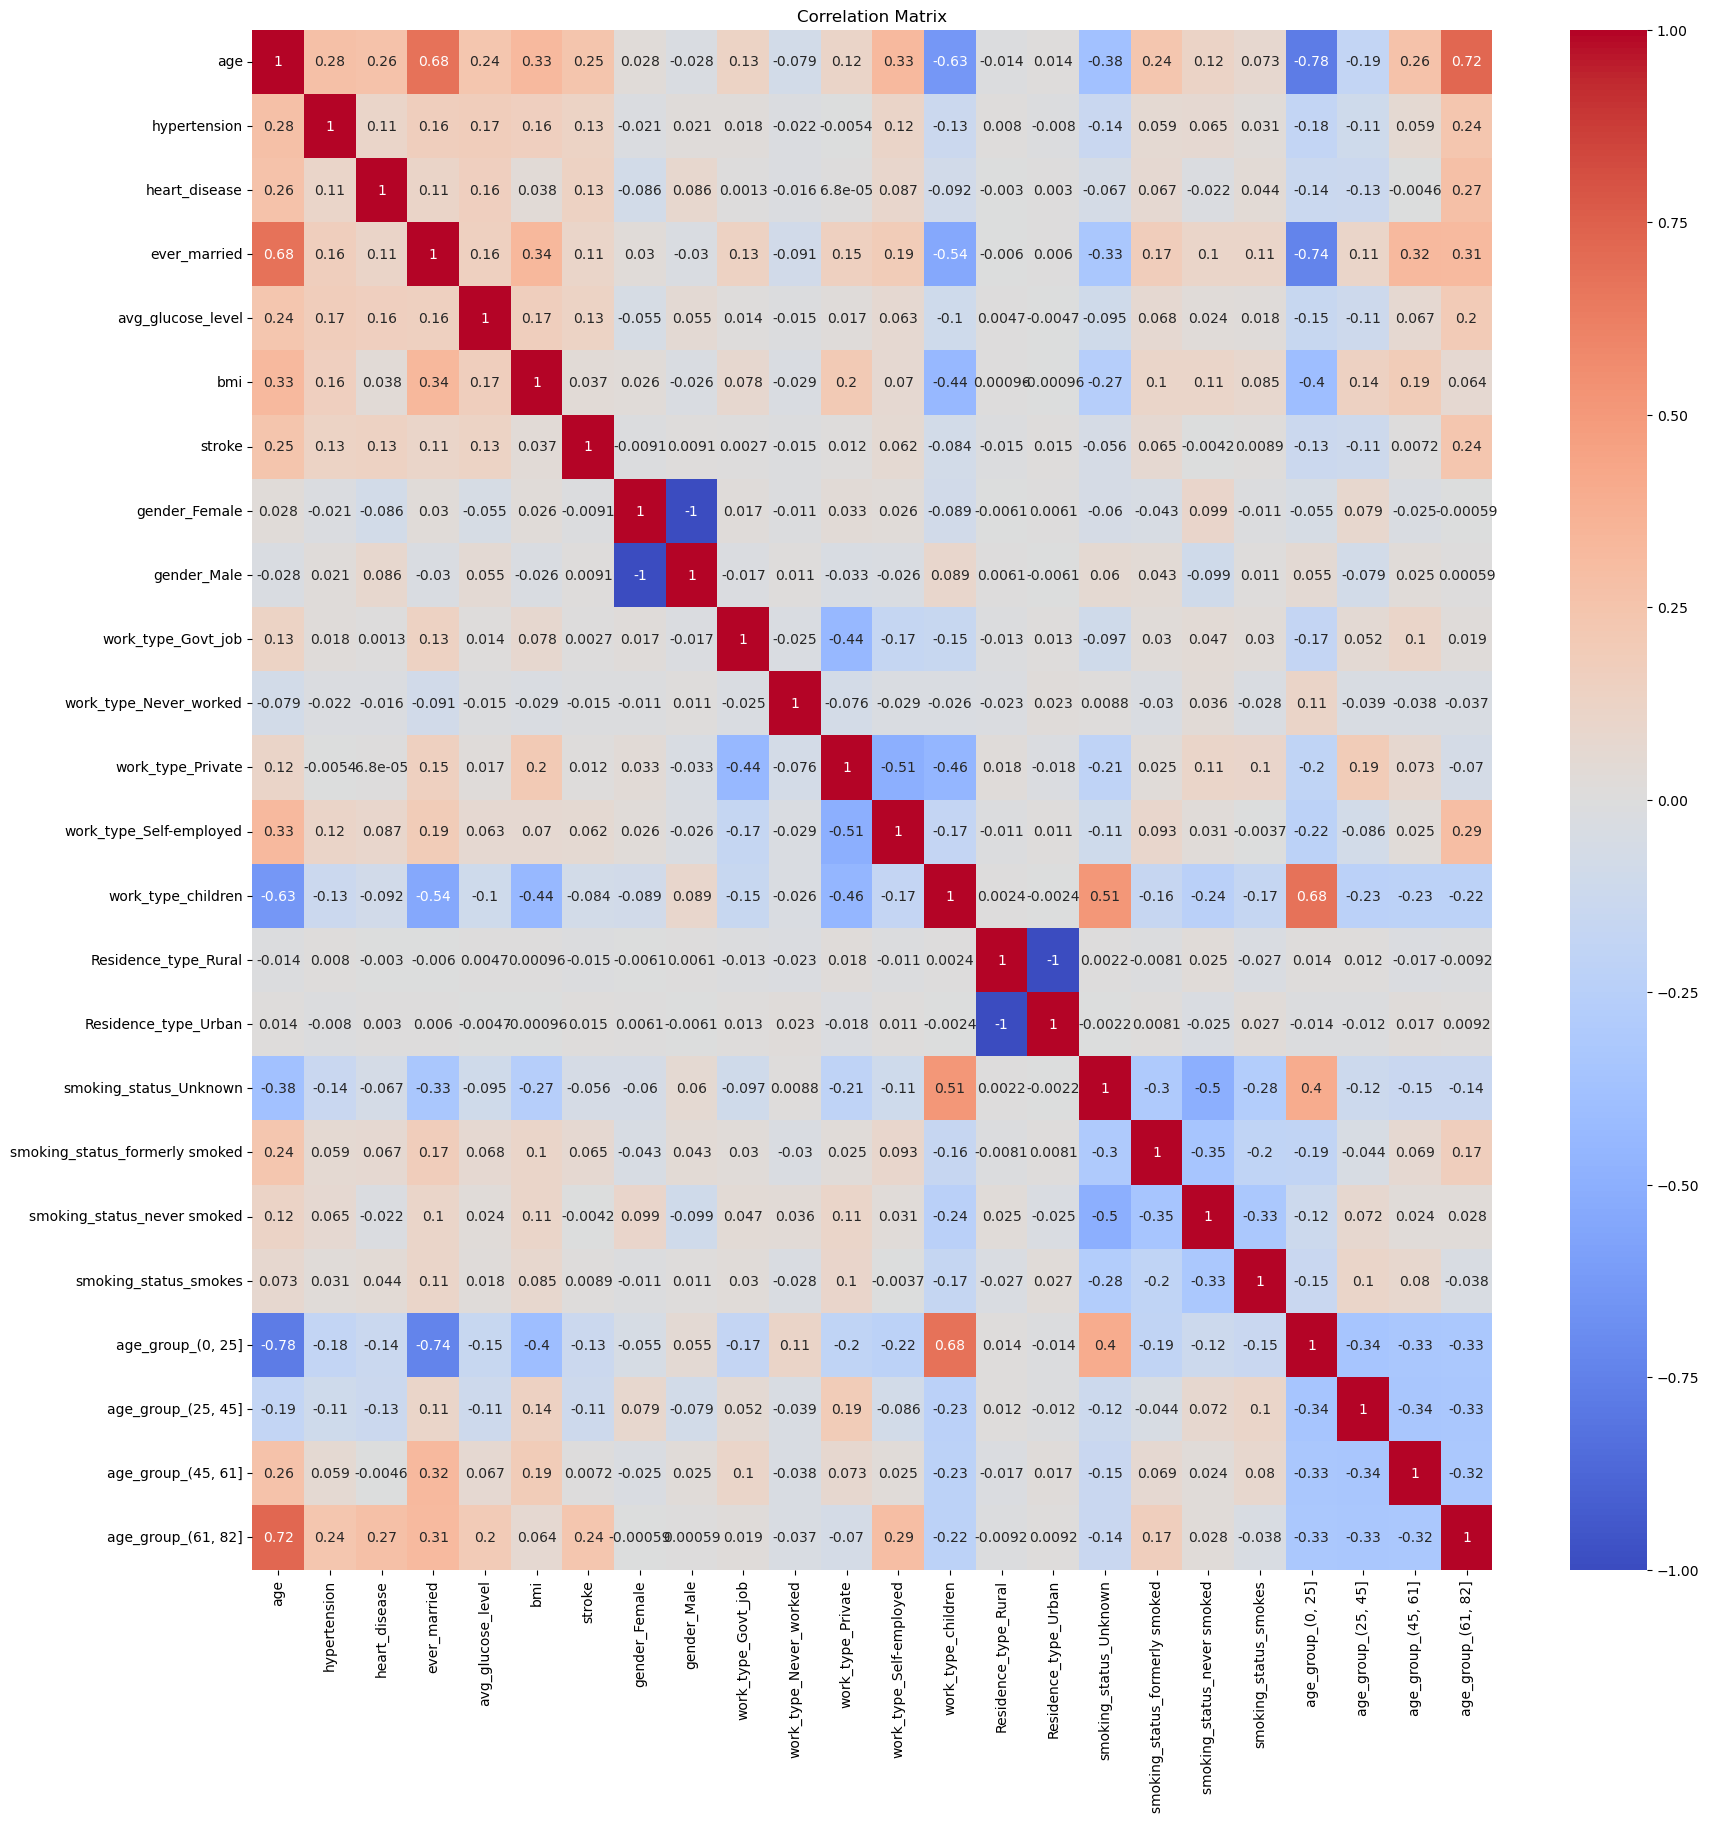

In [44]:
correlation_matrix = df.corr()
correlation_matrix

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

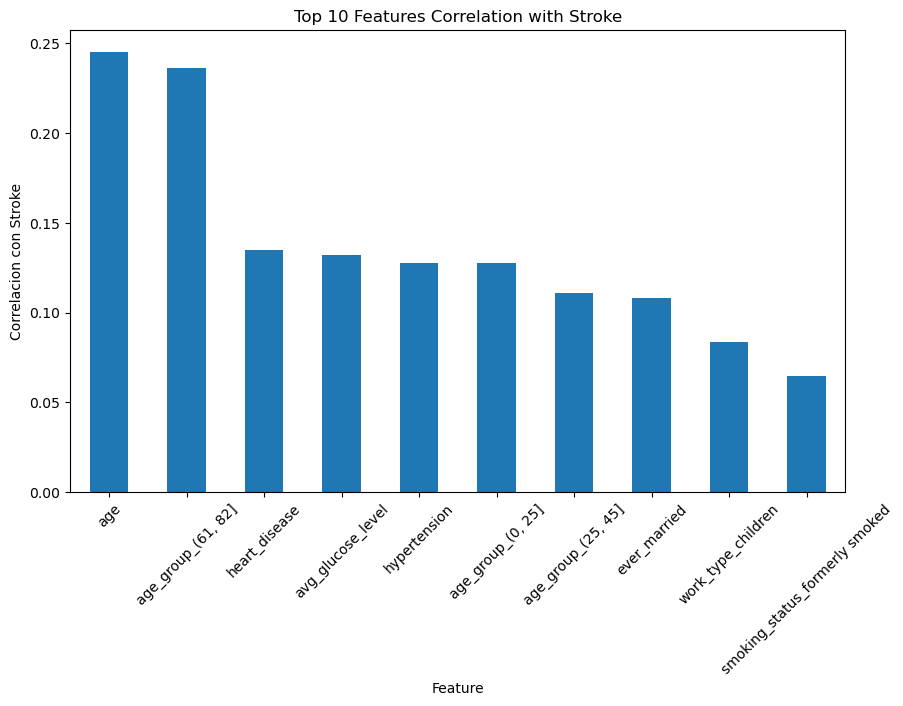

In [45]:
correlation = df.corr()['stroke'].abs().sort_values(ascending=False)

top_10_features = correlation[1:11]

plt.figure(figsize=(10, 6))
top_10_features.plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Correlacion con Stroke')
plt.title('Top 10 Features Correlation with Stroke')
plt.xticks(rotation=45)  
plt.show()

### Lazy predict

Utilizaremos LazyPredict para este analisis.

La biblioteca Lazypredict es una herramienta diseñada para facilitar el proceso de comparación de diferentes modelos de aprendizaje automático en términos de rendimiento. Su objetivo principal es automatizar y simplificar el entrenamiento de múltiples modelos y la evaluación de su rendimiento sin requerir configuraciones detalladas.

In [46]:
#separamos en train y test
x_train , x_test , y_train , y_test = train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)

In [47]:
#escalamos los datos
scaler=StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [48]:
#Corremos el Lazy predict

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)

print(models)

100%|██████████| 31/31 [00:08<00:00,  3.64it/s]

[LightGBM] [Info] Number of positive: 3892, number of negative: 3884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7776, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500514 -> initscore=0.002058
[LightGBM] [Info] Start training from score 0.002058
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.97               0.97     0.97      0.97   
ExtraTreesClassifier               0.97               0.97     0.97      0.97   
LGBMClassifier                     0.97               0.97     0.97      0.97   
BaggingClassifier                  0.97    

Podemos ver que casi todos los modelos tienen muy buen desempeño en accuracy y F1 score, lo cual significa que obtendremos buenos resultados en nuestros analisis en cuanto a matriz de confusion e implementacion manual de los modelos que vimos en esta materia.

### Random Forest 

In [49]:
#armemos un random forest classifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [50]:
#entrenamos y mostramos el accuracy
y_pred = rf.predict(x_test)
print('Predicted')

Predicted


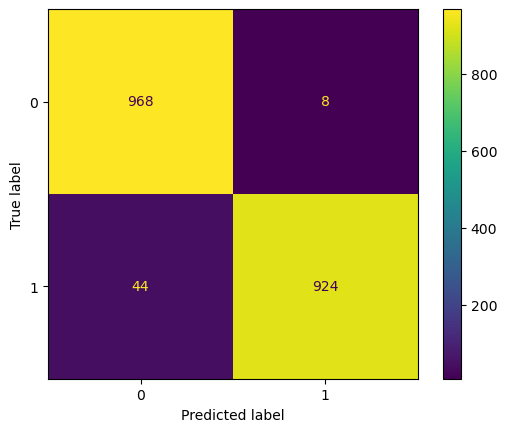

In [51]:
# Validamos con una matriz de confusion
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()  

Como vemos, hay una proprcion baja de valores falsos tanto positivos como negativos, denotando un buen puntaje en metricas de evaluacion, viendo abajo:

In [52]:
# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print("Metricas para Random forest:\n", report)

# Calculamos las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # usamos binary porque es un problema de clasificación binaria
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
mse = mean_squared_error(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

Metricas para Random forest:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       976
           1       0.99      0.95      0.97       968

    accuracy                           0.97      1944
   macro avg       0.97      0.97      0.97      1944
weighted avg       0.97      0.97      0.97      1944

Accuracy: 0.97
Precision: 0.99
Recall: 0.95
F1 Score: 0.97
Mean Squared Error: 0.03


Las metricas de desempeño para el random forest muestra muy buenos valores en cuanto a precision y f1-score, prediciento con una exactitud de 97% valores reales

### Redes Neuronales

Probemos el desempeño de una red neuronal de 2 capas, usando ReLu y una funcion de activacion sigmoidea, utilizaremos BCELoss como funcion de pérdida ya que estamos ante un problema de clasificacion binaria

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# definimos el modelo de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Definimos los hiperparámetros
input_size = x_train.shape[1] # Number of features
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 1000

# creamos el modelo
model = NeuralNetwork(input_size, hidden_size, output_size)

# funcion de perdida y optimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# tensores
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# entrenamiento
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # backpropagation y optimizacion
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # mostrar el progreso de perdida y accuracy cada 10 epochs
    if (epoch+1) % 10 == 0:
        outputs = (outputs >= 0.5).float()
        accuracy = accuracy_score(y_train_tensor, outputs)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/1000], Loss: 0.6459, Accuracy: 0.6838
Epoch [20/1000], Loss: 0.5773, Accuracy: 0.8192
Epoch [30/1000], Loss: 0.5153, Accuracy: 0.8565
Epoch [40/1000], Loss: 0.4577, Accuracy: 0.8711
Epoch [50/1000], Loss: 0.4050, Accuracy: 0.8863
Epoch [60/1000], Loss: 0.3585, Accuracy: 0.8938
Epoch [70/1000], Loss: 0.3187, Accuracy: 0.9025
Epoch [80/1000], Loss: 0.2854, Accuracy: 0.9117
Epoch [90/1000], Loss: 0.2580, Accuracy: 0.9210
Epoch [100/1000], Loss: 0.2353, Accuracy: 0.9276
Epoch [110/1000], Loss: 0.2166, Accuracy: 0.9343
Epoch [120/1000], Loss: 0.2012, Accuracy: 0.9380
Epoch [130/1000], Loss: 0.1884, Accuracy: 0.9415
Epoch [140/1000], Loss: 0.1778, Accuracy: 0.9439
Epoch [150/1000], Loss: 0.1690, Accuracy: 0.9478
Epoch [160/1000], Loss: 0.1615, Accuracy: 0.9510
Epoch [170/1000], Loss: 0.1552, Accuracy: 0.9525
Epoch [180/1000], Loss: 0.1498, Accuracy: 0.9550
Epoch [190/1000], Loss: 0.1450, Accuracy: 0.9550
Epoch [200/1000], Loss: 0.1409, Accuracy: 0.9549
Epoch [210/1000], Loss: 0.137

Podemos ver que la prediccion a traves de Redes neuronales, es bastante acertado a partir de las 60 épocas, mostrando más de 88% de precision y solamente aumentando a medida que subimos las epocas, llegando a un limite bastante alto de ~96% a las 1000 épocas.

Test Accuracy: 0.9666


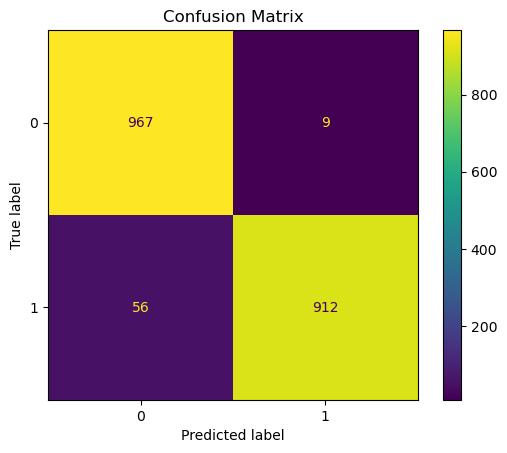

In [54]:
# Evaluacion en el conjunto de prueba
model.eval()
with torch.no_grad():
    test_outputs = model(x_test_tensor)
    test_outputs = (test_outputs >= 0.5).float()
    test_accuracy = accuracy_score(y_test_tensor, test_outputs)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(y_test_tensor, test_outputs)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

In [55]:
# Classification Report
report = classification_report(y_test_tensor, test_outputs)
print('Métricas para redes neuronales:')
print(report)

# Calculamos las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # usamos binary porque es un problema de clasificación binaria
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
mse = mean_squared_error(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

Métricas para redes neuronales:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       976
         1.0       0.99      0.94      0.97       968

    accuracy                           0.97      1944
   macro avg       0.97      0.97      0.97      1944
weighted avg       0.97      0.97      0.97      1944

Accuracy: 0.97
Precision: 0.99
Recall: 0.95
F1 Score: 0.97
Mean Squared Error: 0.03


## Reduccion de dimensionalidad y t-SNE
Analicemos el dataset en terminos de importancia de features en base a sus varianzas utilizando PCA y visualizacion de distribucion del target en 2 dimensiones usando t-SNE 

### PCA

Veamos si se pueden minimizar las features y hasta donde podemos reducir el numero de componentes que expliquen un numero razonable de varianza explicada.

In [56]:
from sklearn.decomposition import PCA

In [57]:
pca = PCA()  # Sin componentes especificados, se calculan todos los componentes
X_pca = pca.fit_transform(x_train)

In [58]:
x_train.shape , X_pca.shape

((7776, 23), (7776, 23))

In [59]:
explained_variance_ratio = pca.explained_variance_ratio_

In [60]:
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


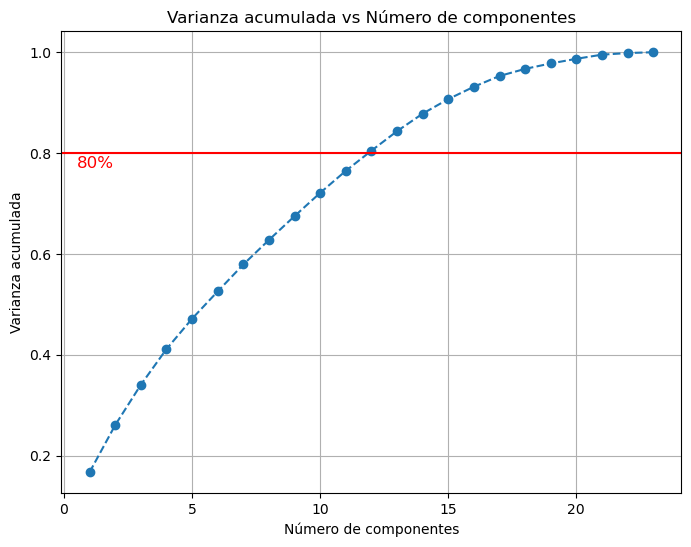

In [61]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza acumulada vs Número de componentes')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.text(0.5, 0.77, '80%', color = 'red', fontsize=12)
plt.grid()
plt.show()

Se observa que con los primeros 12 componentes contienen aproximadamente el 80% de la varianza, mientras que se necesitan alrededor de 23 componentes para describir cerca del 100% de la varianza.

### t-SNE

In [62]:
from sklearn.manifold import TSNE

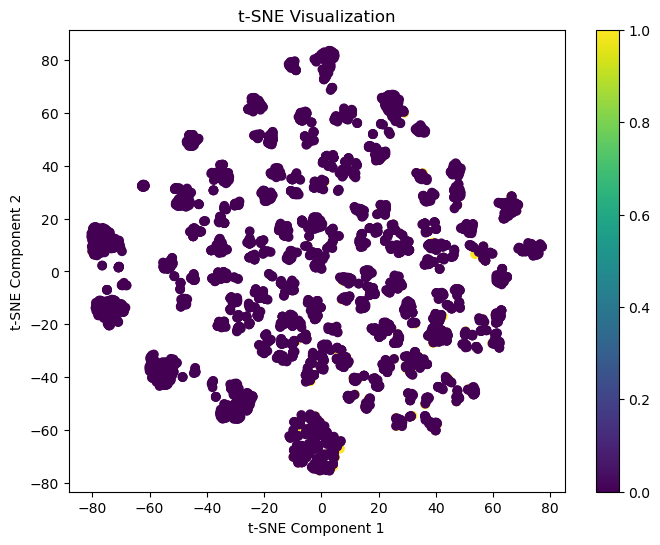

In [63]:
# Step 2: Standardize the data (if not already standardized)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Step 3: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)  # You can change the number of components to 3 for 3D visualization
X_tsne = tsne.fit_transform(X_scaled)

# Step 4: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')  # Assuming y is your target variable
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.colorbar()
plt.show()

En 2 dimensiones y unicamente con t-SNE, no se puede ver gran diferencia y/o distribucion entre valores de 0 y 1, asi que tratemos de hacer un visualizacion en las mismas dos dimensiones pero utilizando kMeans para clusterizar.

In [64]:
import plotly.express as px
from sklearn.cluster import KMeans

# Assuming X_scaled and y are already defined
# Apply t-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
df['label'] = y
df['cluster'] = kmeans.fit_predict(X_tsne)

# Plot using plotly with clusters
fig = px.scatter(df, x='Component 1', y='Component 2', color='cluster', 
                 title='mapa t-SNE with Clusters', symbol='label')
fig.show()

Podemos ver un poco de overlap entre ambas clases, sin embargo kmeans ayuda bastante a hacer una separacion relativamente buena en la estructura de los datos.

In [65]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_tsne, df['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.3378928601741791


Vemos cómo entre -1 y 1, nuestro t-SNE es de 0.3, demostrando lo antes mencionado que los clusters tienen una separacion moderada.

## Conclusiones

En base a las diferentes tecnicas de prediccion antes revisadas y analizadas, podemos ver que utilizando LazyPredict, en general la mayoría de los modelos de prediccion dan muy buenos resultados y precision.

Procedimos tambien a comparar el modelo que mejor predijo de nuestro LazyPredict(RandomForests) con los resultados de una Red Neuronal, en general ambos modelos dieron resultados buenos y parecidos en recall y f1-score, metricas muy importantes para el problema de clasificacion binaria que tenemos.

Tambien implementamos tecnicas de reduccion de dimensionalidad y clusterizacion con PCA, y t-SNE con kMeans respectivamente, lo cual nos ayudó en entender la estructura de los datos de mejor forma.